In [ ]:
!pip install patchify

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lah '/content/drive/MyDrive/Semantic segmentation dataset'

total 33K
-rw------- 1 root root  548 May 29  2020  classes.json
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 1'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 2'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 3'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 4'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 5'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 6'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 7'
drwx------ 2 root root 4.0K Apr 15 12:58 'Tile 8'


In [ ]:
dataset_root_folder = '/content/drive/MyDrive'

In [ ]:
dataset_name = "Semantic segmentation dataset"

In [ ]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks': # 'images
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')): # '.jpg
        #print(image_name)
        a = True

/content/drive/MyDrive/Semantic segmentation dataset/Tile 1/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 2/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 3/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 4/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks


In [ ]:
image_patch_size = 256

In [ ]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)

In [ ]:
image.shape

(544, 509, 3)

In [ ]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [ ]:
len(image_patches)

2

In [ ]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
image_x = image_patches[0,0,:,:]
#MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [ ]:
image_y[0].shape

(256, 256, 3)

In [ ]:
print(type(image))

<class 'numpy.ndarray'>


In [ ]:
type(Image.fromarray(image))

PIL.Image.Image

In [ ]:
image.shape

(544, 509, 3)

In [ ]:
(image.shape[0]//image_patch_size)*image_patch_size

512

In [ ]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [ ]:
type(image_dataset[0])

numpy.ndarray

In [ ]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

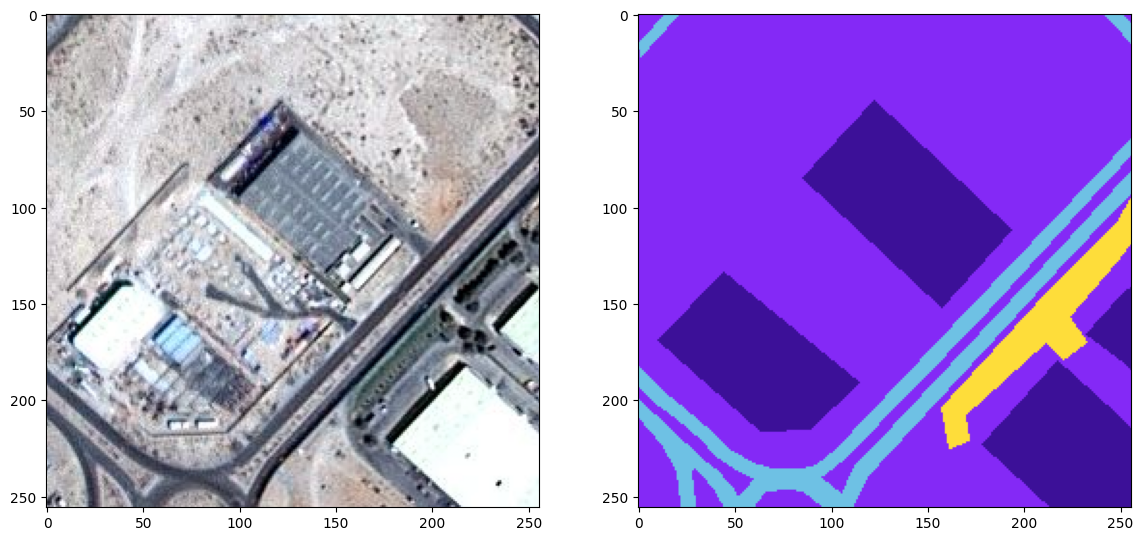

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
mask_dataset.shape[0]

945

In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
print(len(labels))

945


In [ ]:
labels = np.array(labels)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
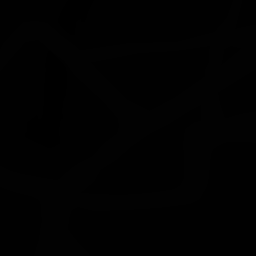

In [ ]:
labels[3]

In [ ]:
labels = np.expand_dims(labels, axis=3)

In [ ]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


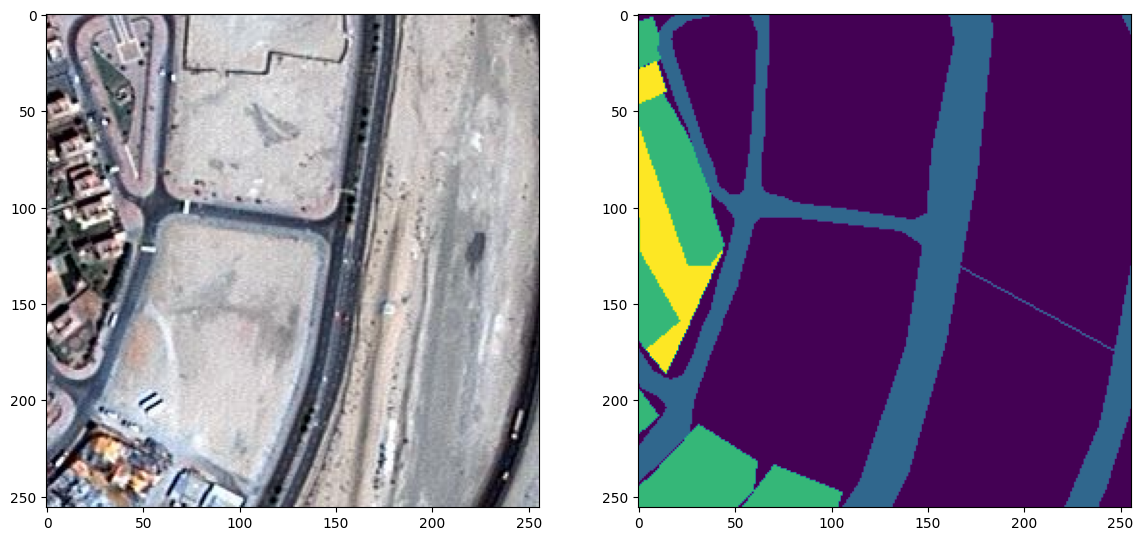

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
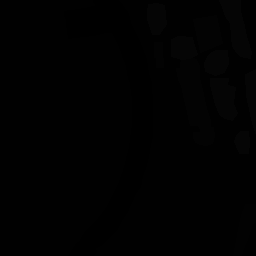

In [ ]:
labels[0][:,:,0]

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
total_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [ ]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [ ]:
master_trianing_dataset = image_dataset

In [ ]:
master_trianing_dataset.shape

(945, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


PART 2

In [ ]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N


**Generating Loss Function**

dice loss > Focal Loss > Total Loss

Total Loss = (Dice loss + (1*Focal Loss))

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)

**Model Compilation **

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/50
51/51 [==============================] - 53s 404ms/step - loss: 1.0014 - accuracy: 0.5290 - jaccard_coef: 0.2549 - val_loss: 0.9920 - val_accuracy: 0.6571 - val_jaccard_coef: 0.2664
Epoch 2/50
51/51 [==============================] - 11s 216ms/step - loss: 0.9817 - accuracy: 0.6845 - jaccard_coef: 0.3543 - val_loss: 0.9819 - val_accuracy: 0.6354 - val_jaccard_coef: 0.3477
Epoch 3/50
51/51 [==============================] - 11s 215ms/step - loss: 0.9659 - accuracy: 0.7110 - jaccard_coef: 0.4161 - val_loss: 0.9775 - val_accuracy: 0.6763 - val_jaccard_coef: 0.4524
Epoch 4/50
51/51 [==============================] - 11s 222ms/step - loss: 0.9561 - accuracy: 0.7356 - jaccard_coef: 0.4860 - val_loss: 0.9761 - val_accuracy: 0.6881 - val_jaccard_coef: 0.4662
Epoch 5/50
51/51 [==============================] - 11s 220ms/step - loss: 0.9522 - accuracy: 0.7470 - jaccard_coef: 0.5042 - val_loss: 0.9668 - val_accuracy: 0.7141 - val_jaccard_coef: 0.4850
Epoch 6/50
51/51 [=================

In [ ]:
history_a = model_history

In [ ]:
history_a.history

{'loss': [1.0014405250549316,
  0.9817155003547668,
  0.9658637046813965,
  0.9560860991477966,
  0.9522188901901245,
  0.9485142827033997,
  0.9464540481567383,
  0.943723738193512,
  0.9417075514793396,
  0.9393528699874878,
  0.9390408396720886,
  0.9344395995140076,
  0.9304525852203369,
  0.9300708770751953,
  0.9264935851097107,
  0.9247836470603943,
  0.9241981506347656,
  0.9217963218688965,
  0.9202811121940613,
  0.9187629818916321,
  0.9172775149345398,
  0.9163275361061096,
  0.9153702259063721,
  0.9143204689025879,
  0.9169036149978638,
  0.9137659668922424,
  0.9125443696975708,
  0.9119452238082886,
  0.909963846206665,
  0.9086660742759705,
  0.9083027243614197,
  0.9074583053588867,
  0.9064894914627075,
  0.9063792824745178,
  0.9056247472763062,
  0.9043698310852051,
  0.9044402837753296,
  0.902772843837738,
  0.9026945233345032,
  0.9087778925895691,
  0.9038654565811157,
  0.9015511274337769,
  0.9002124071121216,
  0.8996109366416931,
  0.8999160528182983,
  0.8

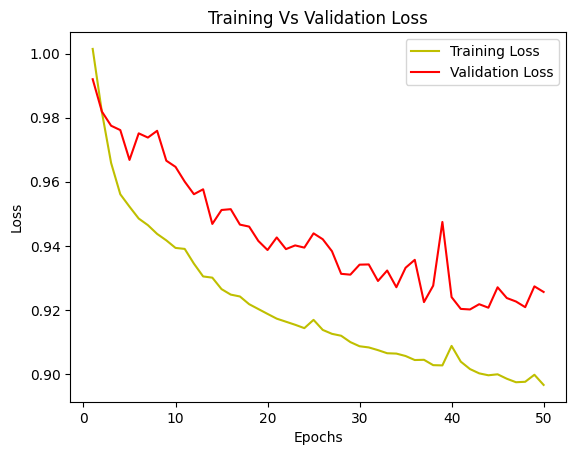

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

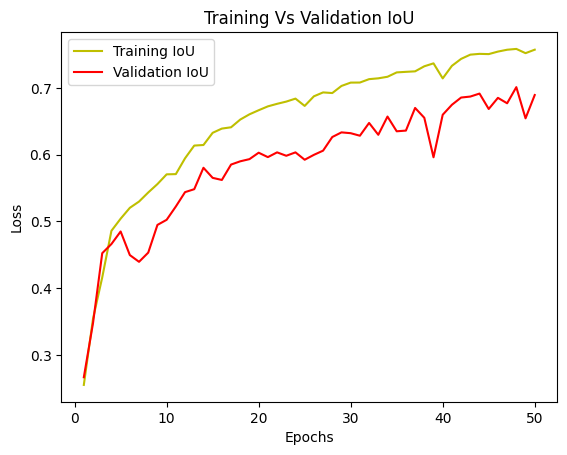

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

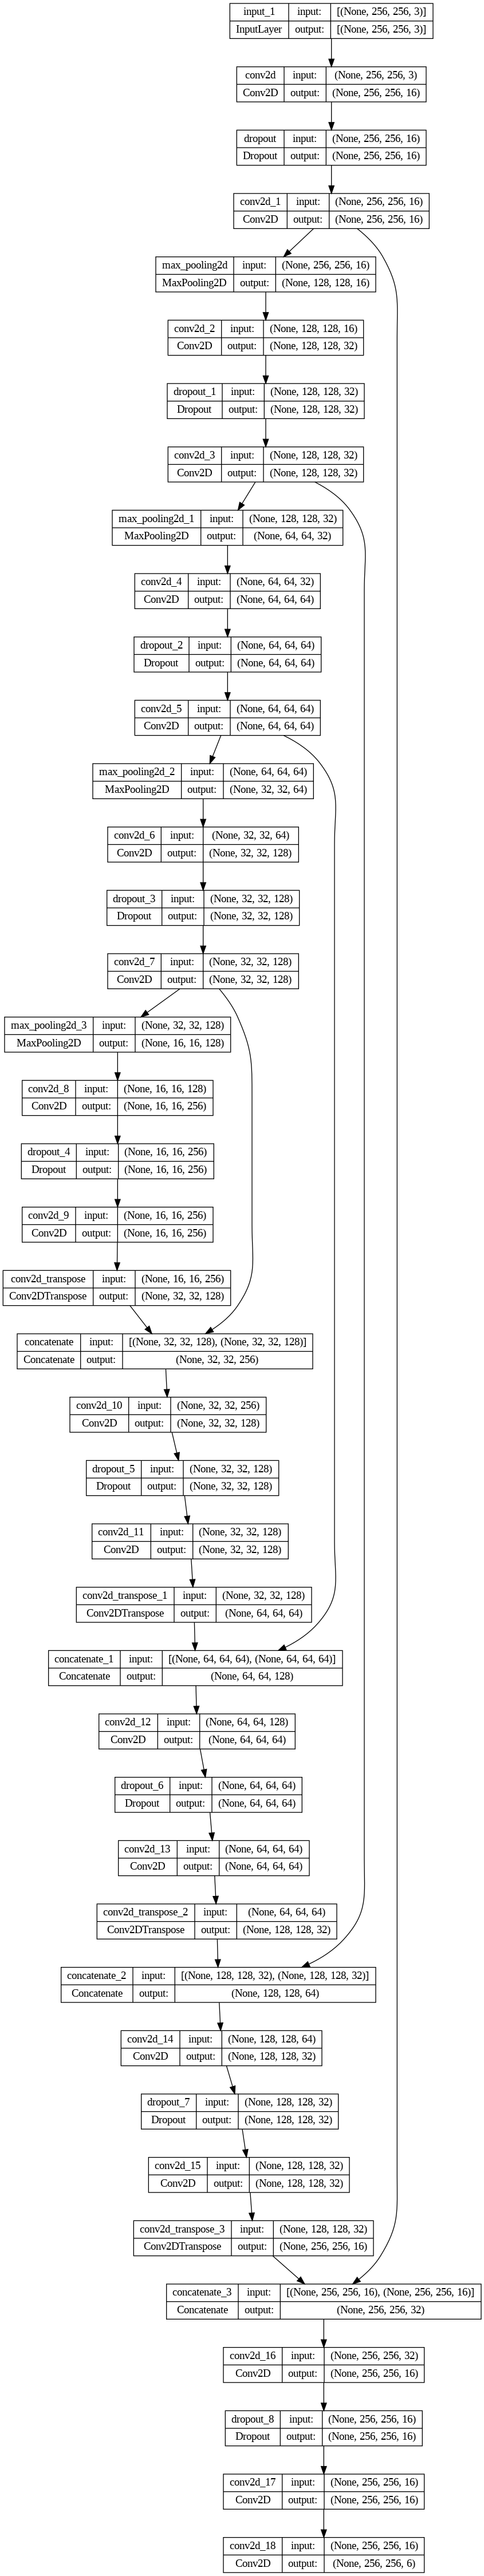

In [ ]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [ ]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show();

plot_loss = PlotLoss()

In [ ]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)

    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

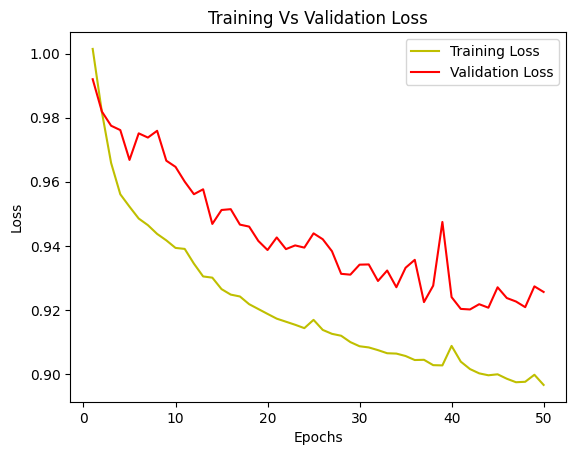

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


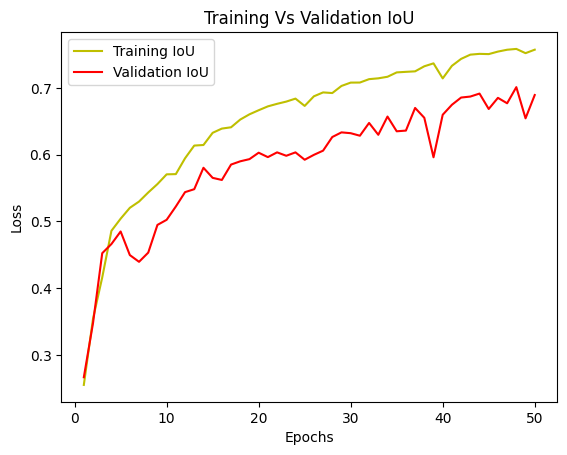

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [ ]:
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 57ms/step


In [ ]:
len(y_pred)

142

In [ ]:
y_pred

array([[[[1.04542496e-02, 7.16734469e-01, 1.22936994e-01,
          1.00485288e-01, 4.54193503e-02, 3.96961486e-03],
         [2.56959116e-03, 8.08279455e-01, 9.04207006e-02,
          8.15427601e-02, 1.60549879e-02, 1.13256054e-03],
         [1.65292528e-03, 8.14662814e-01, 7.73693770e-02,
          8.57752487e-02, 1.95795503e-02, 9.60139267e-04],
         ...,
         [1.29579045e-02, 5.25002122e-01, 1.60109133e-01,
          4.32975404e-02, 2.57887185e-01, 7.46135716e-04],
         [1.68860555e-02, 5.51815093e-01, 1.54172108e-01,
          6.62920475e-02, 2.09834039e-01, 1.00072136e-03],
         [4.24459279e-02, 4.35815215e-01, 1.86764628e-01,
          1.27093986e-01, 1.99633077e-01, 8.24708864e-03]],

        [[1.42550725e-03, 8.26440215e-01, 8.10654983e-02,
          7.60297999e-02, 1.42882634e-02, 7.50686508e-04],
         [1.90752820e-04, 8.99542332e-01, 5.54225184e-02,
          4.08995375e-02, 3.87277920e-03, 7.21268225e-05],
         [1.66366823e-04, 9.11547184e-01, 4.5629

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

142

In [ ]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Comparing Prediction Results

In [ ]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 898ms/step


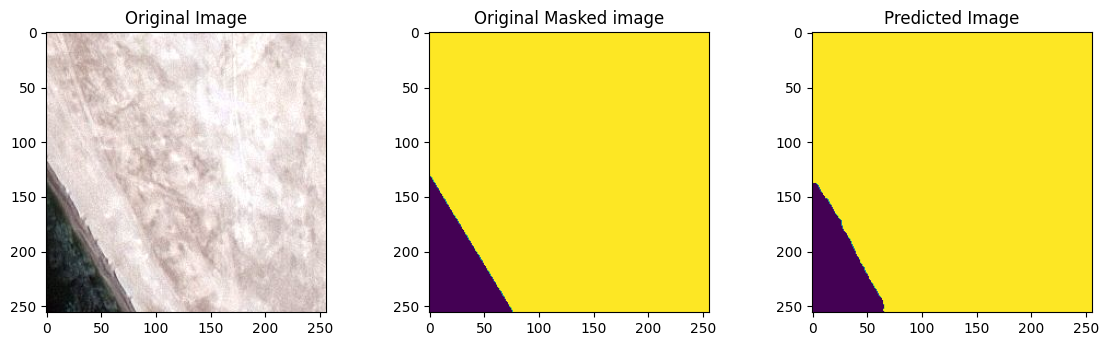

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("/content/drive/MyDrive/satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls -lah

total 372K
drwxr-xr-x 1 root root 4.0K Apr 21 12:42 .
drwxr-xr-x 1 root root 4.0K Apr 21 12:26 ..
drwxr-xr-x 4 root root 4.0K Apr 18 13:24 .config
drwx------ 6 root root 4.0K Apr 21 12:29 drive
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 352K Apr 21 12:42 satellite_model_plot.png


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.4 MB/

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

In [ ]:
from keras import backend as K
from keras.models import load_model

In [ ]:
import gradio as gr

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
satellite_model = load_model('/content/drive/MyDrive/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))


In [ ]:
def process_input_image(image_source):
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  return 'Predicted Masked Image', predicted_image

In [ ]:
my_app = gr.Blocks()

In [ ]:
with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image",width=256,height=256)
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )


In [ ]:
my_app.launch(debug=True,share =True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://60478bb9fac3fa08f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 281ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1788, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1340, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 19ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://60478bb9fac3fa08f1.gradio.live
